# Flocking Robots - Complex Behaviour as an Emergent Property of Local Interactions




It has long been known to roboticists and bird watchers that complex behaviors in groups of autonomous agents can emerge from a combination of primitive behaviors exhibited by each agent independently. Dr. Maja J. Mataric of MIT’s Artificial Intelligence Lab has described several of these primitive behaviors in her work. A few of these are listed below:

* **safe wandering**- minimizes collisions between agents and environment
* **following**- minimizes interference by structuring movement of any two agents
* **aggregation**- gathers the agents
* **dispersion**- dissipates the agents
* **homing**- enables the agent to proceed to a particular location

Note again that every agent exhibits these behaviors only locally. But if all agents exhibit these behaviors, the group can collectively demonstrate more complex behaviors. An example of such a complex behaviour is flocking, also referred to as swarming in the context of insects. According to Mataric, flocking is a combination of *safe wandering, aggregation, dispersion* and *homing*. Look at the following picture for example.

<img src="flock.jpg" width="500" border="1000">

Each bird (autonomous agent) in the flock is directed by a desire to stay close to the other birds it can see, to try its best to not run into them, and to move towards the desired location. These three behaviours, scaled, gives rise to the robust and well organized flock.

In this project, I will try to demonstrate this behavior in a group of robots through a simple python simulation.


### Scenario

N holonomic circular robots of radius 0.25 m with a 360-degree field of view sensors of range 50 m, form a flock and move together through a marked course to a goal location with minimal collisions between each other. There is no explicit communication between the robots. It is assumed that the sensing of each the robot is perfect, that they all home toward both the line through the course and the goal location and that they are capable of omnidirectional motion.


<img src="Course.jpg" width="400" border="1000">




### Simulation Code

This section builds the simulation step by step. The code cells can be executed by pressing shift+enter if you are viewing this on an iPython Notebook. If you are viewing an HTML though, you should paste the code into a .py file and execute it with python.

#### Imports

Following are a few of the libraries we will need for a successful simulation. I will use the matplotlib animation library for a visual demonstration. While it is a very effective tool, its use is rather non-intuitive. A resource I found very helpful in learning how to use this library is located [here](http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/) on Jake VanderPlas's blog.

In [1]:
import numpy as np                                   # handling arrays as vectors and matricies becomes super simple using numpy
from numpy.linalg import norm                        # just a function to calculate the norm of an n-dimesional vector
from scipy.spatial.distance import pdist, squareform # scipi.spatial has several interesting functions for dealing with points in space

# 'pdist' allows one to take an array of m points in n-d space and calculate the distance between each pair in the group. 
# it returns and mC2 numpy array
# 'squareform' takes this array and returns an m x m matrix with cell (i,j) populated by the distance between point i and j

import matplotlib                                    # excellent library for making all sorts of graphs and charts in python
import matplotlib.pyplot as plt                      # actual class within the matplotlib library that does most of the plotting
import matplotlib.animation as animation             # maplotlib's animation class
from IPython.display import HTML                     # this is needed to display the animation in iPython Notebooks
import random                                        # random number generators
matplotlib.rcParams['animation.writer'] = 'avconv'   # These are necessary to make the animation video actually display on the notebook
plt.rcParams["animation.html"] = "html5"             # same as above

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Simulation Setup

The following block of code sets up some of the global variables used in the simulation

In [2]:
'''bob = robot'''
    
'''robot specific simulation parameters'''
num_bobs = 50                                                       # number of robots in the simulation
bob_size = 0.25                                                     # size of each robot
sense_range = 50                                                    # range of robots sensor
avoidence_range = 5                                                 # distance at which other robots will be avoided
max_vel = 100                                                       # robots will move at 'max_vel' m/s at their best
close_enough = 5                                                    # acceptable range for arriving at target
dt = 0.01                                                           # simulation timestep set to 10ms

'''map specific simulation parameters'''
line1 = np.array([[0, 200],[200, 200]])                             # co-ordinate of the first line in the arena
line2 = np.array([[200, 200],[200, 0]])                             # co-ordinates of the second line in the arena
target1 = line1[1]                                                  # first target that the robots must rach
target2 = line2[1]                                                  # second target taht the robots must reach
lines = np.array([line1, line2])
targets = np.array([target1, target2])

'''generating robots, velocities and siatance matrix'''
x_pos = random.sample(range(-50, 51), num_bobs)
y_pos = random.sample(range(150, 251), num_bobs)
bobs_pos = np.array([[i, j] for i, j in zip(x_pos, y_pos)])          # 'bob_pos' contains the locations of all robots
bobs_vel = np.zeros((num_bobs, 2))                                   # 'bobs_vel' contains the velocity of each robots

Lets view what the setup currently looks like.

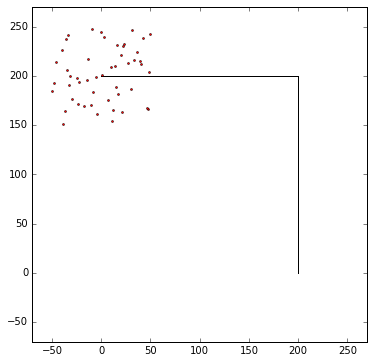

In [3]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, aspect = 'equal', xlim = (-70, 270), ylim = (-70, 270))
line1_plot, = ax.plot([line1[0,0], line1[1,0]], [line1[0,1], line1[1,1]], color = 'black' )
line2_plot, = ax.plot([line2[0,0], line2[1,0]], [line2[0,1], line2[1,1]], color = 'black' )
bobs_plot, = ax.plot(bobs_pos[:, 0], bobs_pos[:, 1], 'ro', ms = 2)


The red dots are our robots. They have been represented to be larger than they are, for ease of visualization.

Let us do a simulation with them moving at random velocities.

In [4]:
# intitialize the array of robot velocities to random numbers between [0, 1)
# scale them by the maximum allowed velocity
bobs_vel = np.random.rand(num_bobs, 2) * max_vel

A Matplotlib animation consists of 3 parts:

* init function - We must define a function that returns the plot we want for the background of each frame of our animation
* update function - We must define a function that takes an integer 'i' as argument, and returns the plot that must appear in the ith frame of the simulation

In [5]:
def init():
    line1_plot.set_data([line1[0,0], line1[1,0]], [line1[0, 1], line1[1,1]])
    line2_plot.set_data([line2[0,0], line2[1,0]], [line2[0, 1], line2[1,1]])
    return(line1_plot, line2_plot)

def update(t):
    new_bobs_pos = bobs_pos + (t * dt) * (bobs_vel)
    bobs_plot.set_data(new_bobs_pos[:, 0], new_bobs_pos[:, 1])
    return (bobs_plot, )

The final element of a matplotliba animation is:

* acquire an animation object, from the animation function in matplotlib

The animation function takes the init and the update functions as keyword arguments, among several others.

* 'frames' - number of frames/iterations for which the update function will be called.
* 'interval' - the number of intervals multiplied by the number of frames gives the length of the animation
* 'blit' - if blit = ture, animation will be smoother

In [6]:
animate = animation.FuncAnimation(fig, update, init_func=init, frames=1000, interval=10, blit=True)
#this object will result in a (1000*10=)10000ms long animation

Finally, just call the animate object. If running this via a .py script, replace the following line of code by 

*plt.show()*

In [7]:
########### CAUTION ###########
# this line takes a lot of time

animate

We now have a generic simulator that can visualize several motion strategies by updating the velocity and position arrays accordingly.

#### Helper Functions

The Following are a few helper functions that will be used repeatedly in this simulation. Most of these take no arguments because the simulation makes use of global variables throughout. Feel free to ignore them for now, and reer back when you encounter them in the code.

In [8]:
def get_centroid():
    
    '''Function that returns centroid of the entire system of robots'''
    
    centroid = np.sum(bobs_pos, axis = 0)/num_bobs                   # The centroid is simply the average of the x and y coordinates of all points
    return centroid


def get_average_distance_from_centroid():
    
    '''Fucntion that returns the average distance of all robots from the cnetroid'''
    
    centroid = get_centroid()                                      
    distance = np.mean([norm(centroid - bobs_pos[i]) for i in range(num_bobs)])
    return distance


def get_distance_matrix():
    
    '''Function that returns a squared distance matrix of all robots in the system'''
    
    distances = pdist(bobs_pos)
    distance_matrix = squareform(distances)
    return distance_matrix


def get_unit_vector(vector):
    
    '''Given a vector as an np array, this function returns the unit vector in that direction'''
    
    return vector/norm(vector)



def get_direction(point1, point2):
    
    '''Given 2 points as np arrays, this function returns the unit vector of the distnce from point 1 to point 2'''
    
    return get_unit_vector(point2 - point1)



def reached_target(target, centroid):
    
    '''Given a taget and the centroid of the system of robots, this function returns true if centroid is close enught to the target'''
    
    if target[1] == target1[1]:
        if (target[0] - centroid[0]) < close_enough:
            return True
    else:
        if (target[1] - centroid[1]) < close_enough:
            return True
    
    return False

#### Motion Primitives (Primitive Behaviors)

Some of the primitive bahviors described above are implemeted through the funtions in the cells that follow. Each of these functions take at least one argument, the index of the robot to which the behavior is being applied. They all return a unit vector for the velocity to be imparted to a robot in order to exhibit the behavior described by that function.

In [9]:
def homing_towards_line(i, line):
    
    '''Function to make a robot home towards a line
    Takes as argument the index of the robot to move and the line towards which it should move
    Returns the unit velocity vector to be emparted to the robot in order to home towards the line'''
    
    bob_position = bobs_pos[i]
    velocity = np.zeros((2))
    
    if line is line1:
        if bob_position[1] > line[0, 1]:
            velocity[1] = -1
        else: 
            velocity = 1
    
    if line is line2:
        if bob_position[0] > line[0, 0]:
            velocity[0] = -1
        else: 
            velocity = 1
        
    return velocity


def homing_towards_point(i, point):
    
    '''Function to make a robot home towards a point
    Takes as argument the index of the robot to move and the point towards which it should move
    Returns the velocity to be imparted to the robot in order to home towards the point'''
    
    bob_position = bobs_pos[i]
    unit_vector = get_direction(bob_position, point)
    velocity = unit_vector
    
    return velocity


def aggregate(i):
    
    '''This function takes as argument the index of a robot
    It checks the robot's sensor readings to see other robots in range
    It then instructs the robot to move towards other robots
    Returns the velocity to be imparted to the robot to for aggregation '''
    
    bob_position = bobs_pos[i]                               # retireve position of current robot
    velocity = np.zeros((2))                                 # This is the vlocity that will be returned
    bob_distances = np.array(distance_matrix[i])             # retrieve distances of all robots to this robot
    close_bobs, = np.where(bob_distances < sense_range)      # get list of indicies for the robots that are in range
    index, = np.where(close_bobs  == i)                      # find the index of this robot in the above list
    close_bobs = np.delete(close_bobs, index)                # delete that entry from the list
    
    # close_bobs now contains the indices of all the robots in range of robot i
    
    # for every robot in sensor range calculate the unit vector to that robot
    # add it to this robot's velocity
    # then find the unit vector of that velocity
    # finally multiply that unit vector for the velocity with the max veocity
    
    if (close_bobs.size != 0):
        for bob in close_bobs:
            bob_position_2 = bobs_pos[bob]
            velocity = velocity + get_direction(bob_position, bob_position_2)
        velocity = get_unit_vector(velocity)
    
    return velocity


def avoid_peers(i): # Same as Dispersion
    
    '''This funtion takes as input the index of a robot
    It checks the robot's sensor readings to see other robots that are too close for comfort
    It then instructs the robot to move away from those robots that are within avoidence range 
    Returns the velocity to be imparted to the robot to for avoidence '''
    
    bob_position = bobs_pos[i]                               # retireve position of current robot
    velocity = np.zeros((2))                                 # This is the vlocity that will be returned
    bob_distances = distance_matrix[i]                       # retrieve distances of all robots to this robot
    close_bobs, = np.where(bob_distances < avoidence_range)  # get list of indicies for the robots that are in range
    index, = np.where(close_bobs  == i)                      # find the index of this robot in the above list
    close_bobs = np.delete(close_bobs, index)                # delete that entry from the list
    
    # for every robot in avoidence range calculate the unit vector to that robot
    # add it to this robot's velocity (don't worry, we wil negate the whole thing at the end)
    # then find the unit vector of tat velocity vector
    # finally multiply that unit vector of the velocity with negateive one
    
    if (close_bobs.size != 0):
        for bob in close_bobs:
            bob_position_2 = bobs_pos[bob]
            velocity = velocity + get_direction(bob_position, bob_position_2)
        velocity = -1 * get_unit_vector(velocity)
    
    return velocity

These primitives can be combined to create more complex motions and behaviors. Let us combine aggregation and dispersion for example. In the following cell I define a function 'simulate' which is the main body of the simulation. Every time this function is called, the velocities of all the robots are updated according to the desired combintion of behaviours.

In [10]:

def simulate(t):
    
    #make sure we are reading from and modifying the global array of positions
    global bobs_pos
    global distance_matrix
    
    #calculate distance matrix
    distance_matrix = get_distance_matrix()
    
    #calculate new velocities
    bobs_vel = np.array([max_vel * get_unit_vector(aggregate(i) + avoid_peers(i)) for i in range(num_bobs)])
    
    #calculate new positions
    bobs_pos = bobs_pos + dt * bobs_vel
    
    return bobs_pos

Recall the update function from earlier. It can now just call our smulate function everytime.

In [11]:
def update(t):

    new_positions = simulate(t)
    bobs_plot.set_data(new_positions[:,0], new_positions[:,1])
    
    return (bobs_plot, )

animate = animation.FuncAnimation(fig, update, init_func=init, frames=1000, interval=8, blit=True)

In [12]:
########### CAUTION ###########
# this line takes a lot of time

animate

As you would have expected, the file the robots try to aggregate towards each other, but also try to avoid each other after a certain distance. In the next section, We will add weights to the behaviors, to achieve the desired effect.

### Homing + Aggregation +  Avoidence  =  Flocking

Finally, the moment we have all been waiting for. We will try to combine all our motion primitives to get flocking behaviour. The weights used are befined below. I have tuned them to achieve the desired effect. Feel free to play around with the weights.

Note that our environment is basically free of any obstacles apart from other robots. Otherwise, we would need a fourth primitive which would allow our robots to avoid real obstacles.

In [16]:
'''weight for motion primitives'''
w_home_point = 1
w_home_line = 0.25
w_aggregate = 2
w_avoid = 4

In [17]:
'''initial path'''
line = line1
point =  target1

'''Region Simulation function'''
#This function gets called every step of the animation
def simulate(t):
    global distance_matrix 
    global bobs_vel
    global bobs_pos
    global centroid
    global avg_dist
    global timestep
    global centroid_line_distance
    global line
    global point
    
    #calculate distance matrix
    distance_matrix = get_distance_matrix()
    
    #calculate centroid
    centroid = get_centroid()
    
    #switch tagets when the first target has basically been reached
    if (reached_target(point, centroid)):
        line = line2
        point = target2


    bobs_vel = np.array([max_vel * get_unit_vector(
            w_home_line * homing_towards_line(i, line)
            + w_home_point * homing_towards_point(i, point) 
            + w_aggregate * aggregate(i) 
            + w_avoid * avoid_peers(i)) 
            for i in range(num_bobs)])
    bobs_pos = bobs_pos + dt * bobs_vel
    
    return bobs_pos

def update(t):

    positions = simulate(t)
    bobs_plot.set_data(positions[:,0], positions[:,1])

    return (bobs_plot, )

animate = animation.FuncAnimation(fig, update, init_func=init, frames=5000, interval=4, blit=True)

In [18]:
##!!!!!!!!!!CAUTION!!!!!!!!!!##
# This cell takes A LOT of time

'''Simulation of 50 robots'''

animate

Ah! The beautiful symphony of robots moving according to plan! I have since tried to make a more generic version of this simulation using a windows form in C#. Find that project [here](https://github.com/TheAdityaKedia/Flocking-Simulator-Windows-form)